In [17]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

# Function to download and load dataset
def load_data():
    page_url = 'https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones'
    page_response = requests.get(page_url)
    if page_response.status_code == 200:
        soup = BeautifulSoup(page_response.content, 'html.parser')
        download_link = soup.select_one('a[href$=".zip"]')['href']
        full_download_url = 'https://archive.ics.uci.edu' + download_link
        response = requests.get(full_download_url)
        if response.status_code == 200:
            with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
                inner_zip_name = 'UCI HAR Dataset.zip'
                with outer_zip.open(inner_zip_name) as inner_zip_file:
                    with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                        with inner_zip.open('UCI HAR Dataset/train/X_train.txt') as myfile:
                            df = pd.read_csv(myfile, delim_whitespace=True, header=None)
                        with inner_zip.open('UCI HAR Dataset/train/y_train.txt') as myfile_y:
                            y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)
    else:
        raise Exception("Failed to download or parse the dataset.")
    return df, y

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np
import time

# Load dataset
df, y = load_data()

#TASK 1 - DO EDA and understand a little about the data.
#Only important thing is to know that it has a lot of features that don't make sense, just a
#bunch of readings from sensors.
#We think many of these features are redundant or irrelevant, and we want to find good features.


<ipython-input-17-0818723ce5cb>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(myfile, delim_whitespace=True, header=None)
<ipython-input-17-0818723ce5cb>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)


In [19]:
print(df.head())

        0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557       558       559       560  
0  0

In [20]:
print(df.describe())

               0            1            2            3            4    \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000   
mean      0.274488    -0.017695    -0.109141    -0.605438    -0.510938   
std       0.070261     0.040811     0.056635     0.448734     0.502645   
min      -1.000000    -1.000000    -1.000000    -1.000000    -0.999873   
25%       0.262975    -0.024863    -0.120993    -0.992754    -0.978129   
50%       0.277193    -0.017219    -0.108676    -0.946196    -0.851897   
75%       0.288461    -0.010783    -0.097794    -0.242813    -0.034231   
max       1.000000     1.000000     1.000000     1.000000     0.916238   

               5            6            7            8            9    ...  \
count  7352.000000  7352.000000  7352.000000  7352.000000  7352.000000  ...   
mean     -0.604754    -0.630512    -0.526907    -0.606150    -0.468604  ...   
std       0.418687     0.424073     0.485942     0.414122     0.544547  ...   
min      -1.00000

In [21]:
print(df.isnull().sum())

0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64


In [22]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB
None


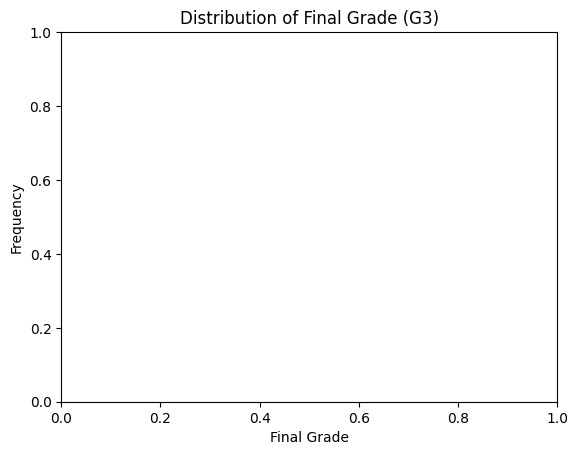

In [23]:

#plt.hist(df['G3'])
plt.title('Distribution of Final Grade (G3)')
plt.xlabel('Final Grade')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Solution to Task 2: Encode class labels

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y.values.ravel())

In [25]:
# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [26]:
#SOLUTION for Task 4

# Split the data into training and testing sets (all features)
X_train_full, X_test_full, y_train, y_test = train_test_split(df_scaled, encoded_y, test_size=0.2, random_state=42)

In [27]:
# SOLUTION FOR TASK 5 and 6

# Define a Pipeline with Gaussian Naive Bayes and train it on the full dataset
start_time = time.time()
classifier_pipeline_full = Pipeline([
    ('classifier', GaussianNB())
])
classifier_pipeline_full.fit(X_train_full, y_train)
y_pred_full = classifier_pipeline_full.predict(X_test_full)
end_time = time.time()
full_features_time = end_time - start_time
accuracy_full = accuracy_score(y_test, y_pred_full)

In [28]:
# SOLUTION -  K-Means for dimensionality reduction
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(df_scaled.T)  # Transpose to treat features as data points
selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
selected_features = df_scaled[:, selected_features_indices]

In [29]:
## SOLUTION for TASK 8


# Split the data with reduced features
X_train_reduced, X_test_reduced = train_test_split(selected_features, test_size=0.2, random_state=42)

import time
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Model with reduced features using Naive Bayes
start_time = time.time()
classifier_pipeline_reduced = Pipeline([
    ('classifier', GaussianNB())
])
classifier_pipeline_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = classifier_pipeline_reduced.predict(X_test_reduced)
end_time = time.time()
reduced_features_time = end_time - start_time
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

# Print comparison results
print("Baseline Model (All Features):")
print("Accuracy:", accuracy_full)
print("Training Time:", full_features_time, "seconds")
print("Number of Features:", X_train_full.shape[1])

print("\nModel with Reduced Features (K-Means):")
print("Accuracy:", accuracy_reduced)
print("Training Time:", reduced_features_time, "seconds")
print("Number of Features:", n_clusters)


Baseline Model (All Features):
Accuracy: 0.7314751869476547
Training Time: 0.09560132026672363 seconds
Number of Features: 561

Model with Reduced Features (K-Means):
Accuracy: 0.8266485384092455
Training Time: 0.01716923713684082 seconds
Number of Features: 50
